In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [5]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [8]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [9]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_channels = 1
num_classes = 10

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

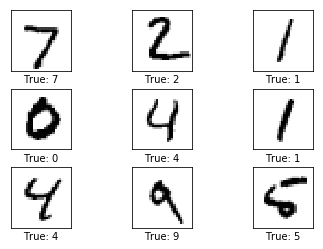

In [11]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [12]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [13]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    #Use pooling to down-sample the image resolution?
    if use_pooling:
        #2x2 max-pooling -> max(2x2 window), then move 2 pixels to next window
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

In [14]:
def flatten_layer(layer):
    layer_shape = layer.get_shape() #layer_shape == [num_images, img_height, img_width, num_channels]

    #Number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    #Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])  #The shape of the flattened layer is now: [num_images, img_height * img_width * num_channels]

    return layer_flat, num_features

In [15]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    #New weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    #Use Relu?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [16]:
## Placeholders

x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [19]:
## Build convolutional layers
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

print("First convolutional layer: ",layer_conv1)

layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

print("Second convolutional layer: ",layer_conv2)

First convolutional layer:  Tensor("Relu_2:0", shape=(?, 14, 14, 16), dtype=float32)
Second convolutional layer:  Tensor("Relu_3:0", shape=(?, 7, 7, 36), dtype=float32)


In [21]:
## Flatten everything
layer_flat, num_features = flatten_layer(layer_conv2)
print("Flatten layer: ", layer_flat)
print("Number of features: ", num_features)

Flatten layer:  Tensor("Reshape_2:0", shape=(?, 1764), dtype=float32)
Number of features:  1764


In [22]:
## Build fully connected layers
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

print("First fully connected layer: ", layer_fc1)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

print("Second fully connected layer: ", layer_fc1)

First fully connected layer:  Tensor("Relu_4:0", shape=(?, 128), dtype=float32)
Second fully connected layer:  Tensor("Relu_4:0", shape=(?, 128), dtype=float32)


In [23]:
## Pred

y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [24]:
# Define cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

# Define cost function
cost = tf.reduce_mean(cross_entropy)

# Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# Performance measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
## Run Tensor, Run!

session = tf.Session()
session.run(tf.global_variables_initializer())

In [26]:
## Optimizer function

total_iterations = 0
train_batch_size = 32

def optimize(num_iterations):
    
    global total_iterations # This ensures we update the global variable rather than a local copy.
    start_time = time.time()

    for i in range(total_iterations, total_iterations + num_iterations):

        #Get first batch and put it into a dict
        x_batch, y_true_batch = data.train.next_batch(train_batch_size) 
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)  # Run Tensor, Run!

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations #Update

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [27]:
## Funtions to plot errors and confusion matrix

def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    print(cm)
    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

In [28]:
# Split the test-set into smaller batches of this size.
test_batch_size = 64

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):

    num_test = len(data.test.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int) # Placeholder array for predictions

    
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test) # End index

        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]

        feed_dict = {x: images, y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

        
    cls_true = data.test.cls # Convenience variable for the true class-numbers of the test-set.
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Optional
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Optional
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [29]:
#Before optimization
print_test_accuracy()

Accuracy on Test-Set: 11.3% (1132 / 10000)


In [30]:
#After one round
optimize(num_iterations=1)
print_test_accuracy()

Optimization Iteration:      1, Training Accuracy:   0.0%
Time elapsed: 0:00:00
Accuracy on Test-Set: 11.6% (1155 / 10000)


In [32]:
#After 100+ rounds
optimize(num_iterations=100)
print_test_accuracy()

Optimization Iteration:    101, Training Accuracy:  53.1%
Time elapsed: 0:00:03
Accuracy on Test-Set: 58.4% (5837 / 10000)


Optimization Iteration:    201, Training Accuracy:  75.0%
Optimization Iteration:    301, Training Accuracy:  96.9%
Optimization Iteration:    401, Training Accuracy:  81.2%
Optimization Iteration:    501, Training Accuracy:  93.8%
Optimization Iteration:    601, Training Accuracy:  90.6%
Optimization Iteration:    701, Training Accuracy:  87.5%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  90.6%
Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy:  90.6%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  90.6%
Optimization Iteration:   1401, Training Accuracy:  81.2%
Optimization Iteration:   1501, Training Accuracy:  87.5%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  93.8%
Optimization Iteration:   1801, Training Accuracy:  93.8%
Optimization I

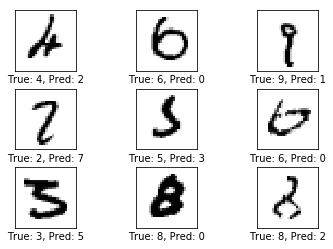

Confusion Matrix:
[[ 974    0    1    0    0    0    1    1    3    0]
 [   0 1130    3    0    0    0    0    0    2    0]
 [   8    6 1006    2    1    0    0    3    6    0]
 [   1    0    1  982    0   17    0    4    4    1]
 [   1    1    3    0  961    0    2    1    3   10]
 [   2    0    0    3    0  881    3    1    1    1]
 [  12    3    1    1    2    5  932    0    2    0]
 [   2    6   13    2    1    0    0  999    1    4]
 [   5    1    3    3    3    3    3    3  944    6]
 [   5    7    0    5    8    6    0    5    1  972]]


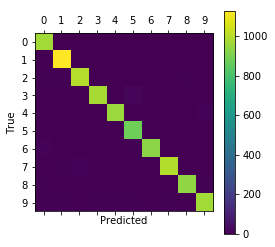

In [33]:
#After 1000+ rounds
optimize(num_iterations=5000)
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [34]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

    
    
def plot_conv_layer(layer, image):
    feed_dict = {x: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]

            ax.imshow(img, interpolation='nearest', cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [35]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

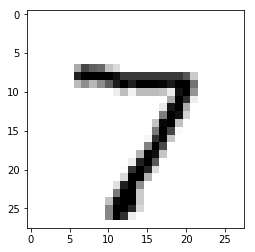

In [36]:
image1 = data.test.images[0]
plot_image(image1)

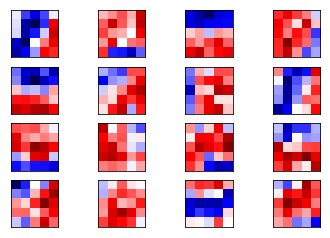

In [37]:
plot_conv_weights(weights=weights_conv1)

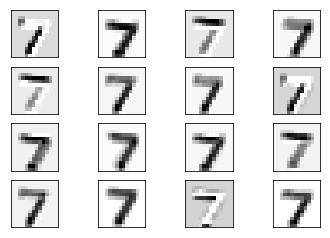

In [38]:
plot_conv_layer(layer=layer_conv1, image=image1)

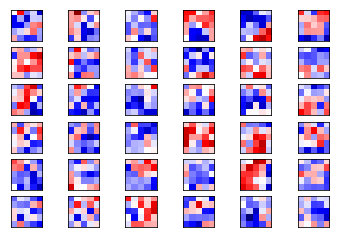

In [39]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

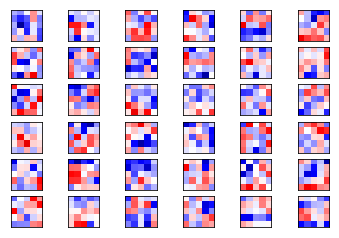

In [40]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

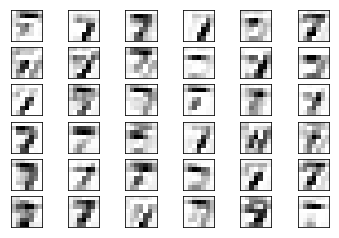

In [41]:
plot_conv_layer(layer=layer_conv2, image=image1)

In [44]:
session.close()